In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [58]:
def warp_img(img):
    # https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html
    img_h = img.shape[0]
    img_w = img.shape[1]

    src = np.float32([[0, img_h], [1207, img_h], [0, img_h // 10], [img_w, img_h // 10]])
    dst = np.float32([[569, img_h], [711, img_h], [0, 0], [img_w, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

    img = img[500:(img_h), 0:img_w] # Apply np slicing for ROI crop
    img = cv2.warpPerspective(img, M, (img_w, img_h)) # Image warping
    img = img[0:img_h-150, 350:900]
    return img


def apply_region_of_interest(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    return img[500:(img_h), 0:img_w]

def apply_gaussian_blur(img, kernel_size=(5, 5)):
    return cv2.GaussianBlur(img, kernel_size, 0)

def apply_canny_edge(img, low_threshold=100, high_threshold=200):
    return cv2.Canny(img, low_threshold, high_threshold)

def apply_dilation(img, kernel_size=(3, 3)):
    return cv2.dilate(img, np.ones(kernel_size, np.uint8))

def detect_hough_lines(img):
    return cv2.HoughLinesP(
        img,
        rho=1,
        theta=np.pi/180,
        threshold=20,
        minLineLength=2,
        maxLineGap=5
    )

def draw_hough_lines(img, lines):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), 255, 5)
    return img

def find_largest_contour(img_lines):
    contours, _ = cv2.findContours(img_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea, default=None)

def draw_rectangle_features(img, rect):
    width = min(rect[1][1], rect[1][0])
    box = np.int0(cv2.boxPoints(rect))
    cv2.drawContours(img, [box], 0, (255, 0, 0), 2)
    cv2.circle(img, tuple(map(int, rect[0])), 5, (255, 0, 0), -1)
    cv2.putText(
        img, str(round(rect[2], 2)), tuple(map(int, rect[0])),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )
    bottom_left = box[np.argmin(box[:, 1])]
    cv2.putText(
        img, str(round(width, 2)), (bottom_left[0] - 50, bottom_left[1]),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )
    return img

def process_image(img):
    img_w, img_h = img.shape[1], img.shape[0]
    img = warp_img(img)

    img_blur = apply_gaussian_blur(img.copy())
    img_canny = apply_canny_edge(img_blur)
    img_canny = apply_dilation(img_canny)
    
    lines = detect_hough_lines(img_canny.copy())
    img_hou = np.zeros((img_h, img_w), dtype=np.uint8)
    draw_hough_lines(img_hou, lines)
    
    biggest_rectangle = find_largest_contour(img_hou)
    if biggest_rectangle is None:
        return
    
    rect = cv2.minAreaRect(biggest_rectangle)
    width = min(rect[1][1], rect[1][0])
    angle = rect[2]
    print(f"angle: {angle:.2f}, \t width: {width:.2f}")
    img = draw_rectangle_features(img, rect)
    return img, img_blur, img_hou


In [67]:
def show_imgs(imgs):
    rows = int(np.ceil(len(imgs) / 5))
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 15))
    for img, ax in zip(imgs, axs.flatten()):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### Expermintation results
1. Angle 0, Speed 0 detection is working decently
2. Angle 0, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
3. Angle 0, Speed 15 detection is working correctly in terms of the anlge, but the speed is not detected correctly and it depends on the distance of the segment from the bottom of the image. Some form of normalization is needed.
4. Angle 0, Speed 30 detection is same as above.

5. Angle 10, Speed 5 detection seems to working for the most part. Some rounding to values needs to be done.
6. Angle 10, Speed 15 detection is similar to above. There migh be an overlap with the angle 20.

7. Angle 20, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
8. Angle 20, Speed 15 detection is 

<br><br>

##### Notes:
- Using a smaller size for the images would greatly improve the performance.

angle: 77.47, 	 width: 38.07
angle: 77.47, 	 width: 38.07
angle: 77.60, 	 width: 37.98
angle: 77.47, 	 width: 38.72
angle: 77.12, 	 width: 35.96
angle: 90.00, 	 width: 102.00
angle: 90.00, 	 width: 94.00
angle: -0.00, 	 width: 100.00
angle: 90.00, 	 width: 101.00
angle: -0.00, 	 width: 100.00
angle: 89.66, 	 width: 62.30
angle: 89.56, 	 width: 63.30
angle: 0.00, 	 width: 63.00
angle: 89.65, 	 width: 62.73
angle: 90.00, 	 width: 63.00
angle: 11.63, 	 width: 38.49
angle: 11.89, 	 width: 37.85
angle: 11.98, 	 width: 37.50
angle: 11.99, 	 width: 38.18
angle: 11.77, 	 width: 38.30
angle: 11.92, 	 width: 19.41
angle: 11.85, 	 width: 19.88
angle: 11.61, 	 width: 20.13
angle: 11.57, 	 width: 20.07
angle: 11.62, 	 width: 19.65


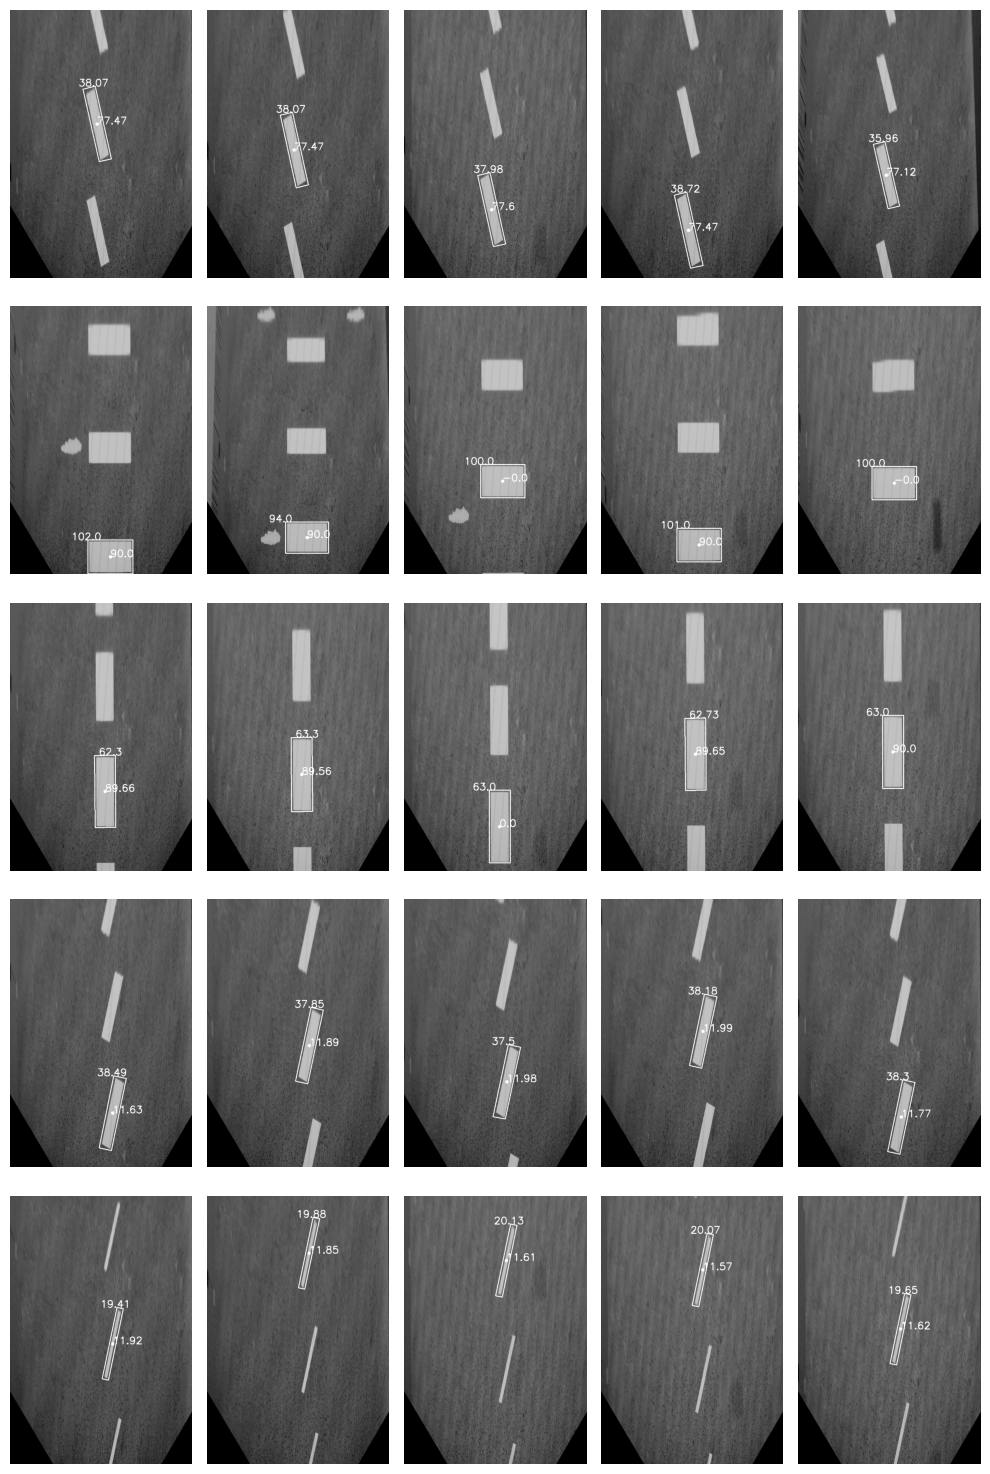

In [68]:
folder = "imgs"
images = []
imgs_canny = []
imgs_hou = []

for img_name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
    img, img_canny, img_hou = process_image(img)
    images.append(img)
    imgs_canny.append(img_canny)
    imgs_hou.append(img_hou)

show_imgs(images)
# show_imgs(imgs_canny)
# show_imgs(imgs_hou)